In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [3]:
import os
import time
# import geohash
import logging
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
from sqlalchemy import create_engine

In [4]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine
import pandas as pd
import time

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [5]:
schema_name = {'cda': 'cuebiq.paas_cda_pe_v3'}
pe_dl_table = f"{schema_name['cda']}.device_location_uplevelled"

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [7]:
# country_code = 'CO'
# country_code = 'ID'
# country_code = 'IN'
country_code = 'MX'

pathFolder = "/home/jovyan/Data/daily_pd3/".format(country_code)
Path(pathFolder).mkdir(parents=True, exist_ok=True)

In [ ]:
pe_dl = sql_engine.read_sql(
    f"""
    SELECT 
        geohash_3, 
        COUNT(*) AS no_of_points,
        COUNT(DISTINCT(cuebiq_id)) AS no_of_unique_users,
        local_date
    FROM 
    (
        SELECT 
            cuebiq_id,
            TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) AS event_datetime_local,
            geohash_encode(lat, lng, 3) AS geohash_3, 
            DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date
        FROM {pe_dl_table}
        WHERE 
            country_code = '{country_code}' 
            AND event_zoned_datetime IS NOT NULL
            AND TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) IS NOT NULL
            AND DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) BETWEEN date_parse('20200101', '%Y%m%d') AND date_parse('20201231', '%Y%m%d')
            AND lat <> 0
            AND lng <> 0
    ) subquery
    GROUP BY geohash_3, local_date
    """
)


# Convert 'local_date' to 'yyyymmdd' format
pe_dl['local_date'] = pd.to_datetime(pe_dl['local_date']).dt.strftime('%Y%m%d').astype(int)
pe_dl = pe_dl.drop_duplicates() # Remove duplicates

# pe_dl

fileName = "{}{}_2020_daily_agg3.csv".format(pathFolder,country_code)
pe_dl.to_csv(fileName,  sep=',', index=False)

# Check

In [10]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [35]:
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
path_pattern = '/home/jovyan/Data/daily_pd3/IN_2020_daily_agg*.csv'
file_list = glob.glob(path_pattern)
file_sub_list = [path for path in file_list]
file_sub_list

['/home/jovyan/Data/daily_pd3/IN_2020_daily_agg3.csv']

In [49]:
dataframes = []

# Loop through the list of files and read each file into a DataFrame
for file in file_list:
    df = pd.read_csv(file)
    dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df

,geohash_3,no_of_points,no_of_unique_users,local_date
0,tsv,105791,2113,20200123
1,tdr,416346,9489,20200123
2,tec,26585,562,20200123
3,t9z,68748,1532,20200122
4,tgv,26424,506,20200124
...,...,...,...,...
69430,w1c,1,1,20200602
69431,t9u,69,1,20200301
69432,wj5,1,1,20200927
69433,w43,12,1,20201231


In [50]:
combined_df_10 = combined_df[combined_df['no_of_unique_users'] >= 10]
combined_df_10

,geohash_3,no_of_points,no_of_unique_users,local_date
0,tsv,105791,2113,20200123
1,tdr,416346,9489,20200123
2,tec,26585,562,20200123
3,t9z,68748,1532,20200122
4,tgv,26424,506,20200124
...,...,...,...,...
69288,tdk,438,17,20201221
69290,te9,441,14,20201202
69303,ttv,475,33,20201118
69306,wh2,807,35,20201220


## Check Duplicates

In [51]:
combined_df_10['geohash_3'] = combined_df_10['geohash_3'].astype(str)
combined_df_10['no_of_points'] = combined_df_10['no_of_points'].astype(int)
combined_df_10['no_of_unique_users'] = combined_df_10['no_of_unique_users'].astype(int)
combined_df_10['local_date'] = combined_df_10['local_date'].astype(int)

combined_df_10 = combined_df_10.drop_duplicates()
combined_df_10

/tmp/ipykernel_174/3276517867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_10['geohash_3'] = combined_df_10['geohash_3'].astype(str)
/tmp/ipykernel_174/3276517867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_10['no_of_points'] = combined_df_10['no_of_points'].astype(int)
/tmp/ipykernel_174/3276517867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,geohash_3,no_of_points,no_of_unique_users,local_date
0,tsv,105791,2113,20200123
1,tdr,416346,9489,20200123
2,tec,26585,562,20200123
3,t9z,68748,1532,20200122
4,tgv,26424,506,20200124
...,...,...,...,...
69288,tdk,438,17,20201221
69290,te9,441,14,20201202
69303,ttv,475,33,20201118
69306,wh2,807,35,20201220


## Check missing date

In [52]:
unique_values_count = combined_df_10["local_date"].unique()
all_dates = pd.date_range(start='2020-01-01', end='2020-12-31').strftime('%Y%m%d').astype(int)
all_dates = np.array(all_dates)
missing_dates = np.setdiff1d(all_dates, unique_values_count)

missing_dates

array([], dtype=int64)

## Check with figure

In [53]:
# Aggregating the DataFrame by local_date
aggregated_df = combined_df_10.groupby('local_date').agg({
    'no_of_points': 'sum',
    'no_of_unique_users': 'sum',
    'geohash_3': ['nunique', 'count']
}).reset_index()

# Flatten the MultiIndex columns
aggregated_df.columns = ['local_date', 'total_no_of_points', 'total_no_of_unique_users', 'unique_geohash_3', 'sum_geohash_3']
aggregated_df['local_date'] = aggregated_df['local_date'].astype(str)
aggregated_df

,local_date,total_no_of_points,total_no_of_unique_users,unique_geohash_3,sum_geohash_3
0,20200101,12781107,208415,188,188
1,20200102,12795880,200778,192,192
2,20200103,13065186,206103,190,190
3,20200104,14422389,201388,188,188
4,20200105,12442456,202600,189,189
...,...,...,...,...,...
361,20201227,5481165,165614,185,185
362,20201228,5404978,160620,187,187
363,20201229,5542529,168701,187,187
364,20201230,5572184,164849,189,189


2024-09-09 22:06:42,217 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 22:06:42,224 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 22:06:42,595 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 22:06:42,602 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


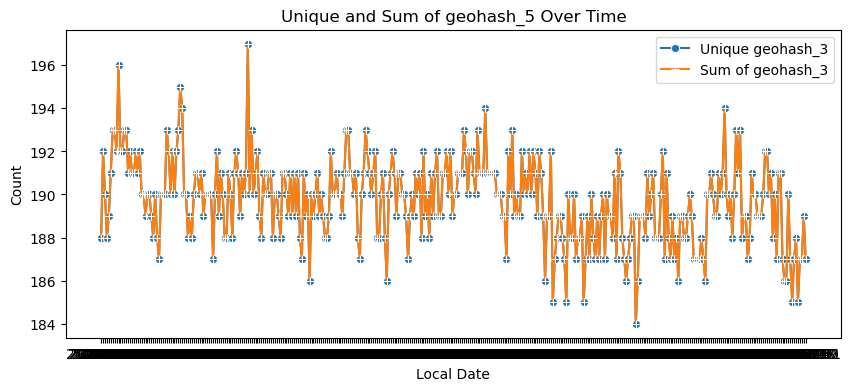

In [54]:
# Plot 1: unique_geohash_5 and sum_geohash_5
plt.figure(figsize=(10, 4))
sns.lineplot(data=aggregated_df, x='local_date', y='unique_geohash_3', marker='o', label='Unique geohash_3')
sns.lineplot(data=aggregated_df, x='local_date', y='sum_geohash_3', marker='+', label='Sum of geohash_3')
plt.title('Unique and Sum of geohash_5 Over Time')
plt.xlabel('Local Date')
plt.ylabel('Count')
plt.legend()
plt.grid(False)
plt.show()

2024-09-09 22:06:43,851 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 22:06:43,858 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


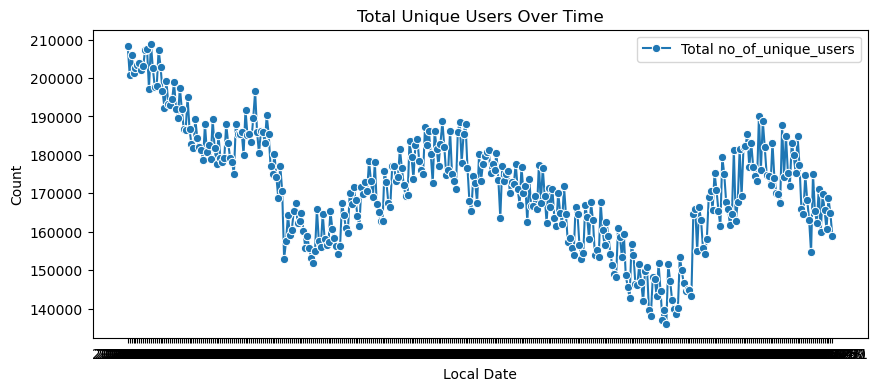

In [55]:
# Plot 2: total_no_of_points and total_no_of_unique_users
plt.figure(figsize=(10, 4))
sns.lineplot(data=aggregated_df, x='local_date', y='total_no_of_unique_users', marker='o', label='Total no_of_unique_users')
plt.title('Total Unique Users Over Time')
plt.xlabel('Local Date')
plt.ylabel('Count')
plt.legend()
plt.grid(False)
plt.show()

2024-09-09 22:06:45,489 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-09 22:06:45,496 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


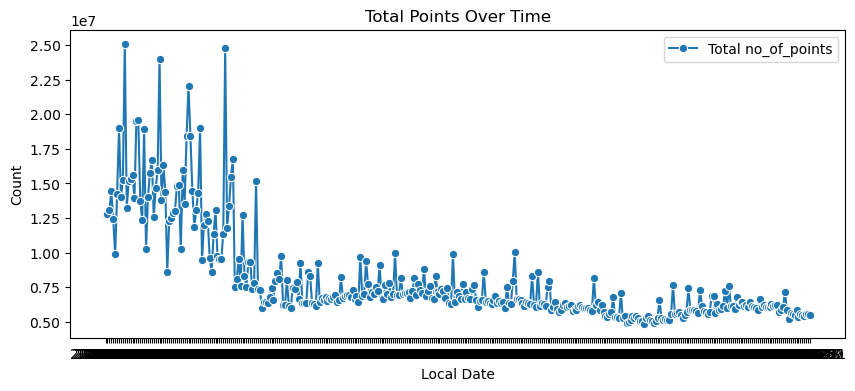

In [56]:
# Plot 2: total_no_of_points and total_no_of_unique_users
plt.figure(figsize=(10, 4))
sns.lineplot(data=aggregated_df, x='local_date', y='total_no_of_points', marker='o', label='Total no_of_points')
plt.title('Total Points Over Time')
plt.xlabel('Local Date')
plt.ylabel('Count')
plt.legend()
plt.grid(False)
plt.show()

## Export 

In [57]:
# combined_df_10 = pd.read_csv('/home/jovyan/Data/daily_pd3/Clean/' + 'pd_mx_2019_agg3_daily.csv')
# combined_df_10

In [45]:
# combined_df_10
combined_df_10['no_of_points'].sum()/1744305542

0.999741167479476

In [58]:
# Save the combined DataFrame to a new CSV file
folder_path = '/home/jovyan/Data/daily_pd3/Clean/'
combined_df_10.to_csv(folder_path + 'pd_in_2020_agg3_daily.csv', index=False)

# For single day to understand the data

In [ ]:
# single month
pe_dl = sql_engine.read_sql(
    f"""
    SELECT 
        geohash_5, 
        COUNT(*) AS no_of_points,
        COUNT(DISTINCT(cuebiq_id)) AS no_of_unique_users,
        local_date
    FROM 
    (
        SELECT 
            cuebiq_id,
            TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) AS event_datetime_local,
            geohash_encode(lat, lng, 5) AS geohash_5, 
            DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date
        FROM {pe_dl_table}
        WHERE 
            country_code = '{country_code}' 
            AND event_zoned_datetime IS NOT NULL
            AND TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) IS NOT NULL
            AND DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) BETWEEN date_parse('20190101', '%Y%m%d') AND date_parse('20190131', '%Y%m%d')
    ) subquery
    GROUP BY geohash_5, local_date
    """
)


fileName = "{}{}_daily_agg5_jan.csv".format(pathFolder,country_code)
pe_dl.to_csv(fileName,  sep=',', index=False)


In [13]:
# before aggregation
country_code = 'CO'

query = f"""
SELECT 
    cuebiq_id,
    TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) AS event_datetime_local,
    geohash_encode(lat, lng, 5) AS geohash_5, 
    DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS local_date

    -- extract(DAY FROM date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))  day1,
    -- extract(MONTH FROM date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))  month1,
    -- DAY(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS day2,
    -- MONTH(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS month2,
    -- WEEK(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) AS week_number
FROM {pe_dl_table}
WHERE 
    country_code = '{country_code}' 
    AND event_zoned_datetime IS NOT NULL
    AND TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) IS NOT NULL
    AND DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) BETWEEN date_parse('20191201', '%Y%m%d') AND date_parse('20191202', '%Y%m%d')
"""

pe_dl_table_gen = sql_engine.read_sql(query)
pe_dl_table_gen

,cuebiq_id,event_datetime_local,geohash_5,local_date
0,2861571503,2019-12-02 21:09:55,d2f5x,2019-12-02
1,2861571503,2019-12-02 21:26:29,d2f5x,2019-12-02
2,2861571503,2019-12-02 22:16:05,d2f5x,2019-12-02
3,2861571503,2019-12-02 18:02:02,d2f5x,2019-12-02
4,2861571503,2019-12-02 18:02:02,d2f5x,2019-12-02
...,...,...,...,...
3110039,2071513854,2019-12-02 06:50:39,d2j01,2019-12-02
3110040,2092368429,2019-12-02 20:22:27,d2g6f,2019-12-02
3110041,2092368429,2019-12-02 20:22:27,d2g6f,2019-12-02
3110042,2092368429,2019-12-02 20:36:31,d2g6f,2019-12-02
